# Citrine Research Scientist Challenge

By Eric Muckley (ericmuckley@gmail.com)

November 2019

# Prepare the data


## Import packages and define methods

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 10 17:24:53 2019
@author: Eric Muckley (ericmuckley@gmail.com)
"""

import time
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import linregress
from sklearn.cluster import OPTICS

# change matplotlib settings to make plots look nicer
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.minor.width'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.minor.width'] = 3
plt.rcParams['ytick.major.width'] = 3

def plot_setup(labels=['X', 'Y'], fsize=18, setlimits=False, limits=[0,1,0,1],
               title='', legend=True, save=False, filename='plot.jpg'):
    """Creates a custom plot configuration to make graphs look nice.
    This can be called with matplotlib for setting axes labels,
    titles, axes ranges, and the font size of plot labels.
    This should be called between plt.plot() and plt.show() commands."""
    plt.xlabel(str(labels[0]), fontsize=fsize)
    plt.ylabel(str(labels[1]), fontsize=fsize)
    plt.title(title, fontsize=fsize)
    fig = plt.gcf()
    fig.set_size_inches(6, 4)
    if legend:
        plt.legend(fontsize=fsize-4)
    if setlimits:
        plt.xlim((limits[0], limits[1]))
        plt.ylim((limits[2], limits[3]))
    if save:
        fig.savefig(filename, dpi=120, bbox_inches='tight')
        plt.tight_layout()

def norm_arr(arr):
    """Normalizes a 1D array by setting mean = 0 and std. dev. = 1."""
    return np.subtract(arr, np.mean(arr)) / np.std(arr)

Install lolopy for use of random forests with uncertainty estimates.

In [2]:
!pip install lolopy
from lolopy.learners import RandomForestRegressor

## Import the data

First we import the data. The dataset was created using the Citrination
Data Views feature on the Citrination website, then stored on Github for
easy retrieval. Here we are cloning the Github repository in order to import
the csv file. This method of retrieving the data is convinent when using a
Jupyter notebook created using Google Colab, since the data can be accessed
from anywhere. The data file can be found inside my Github repository:
https://github.com/ericmuckley/datasets/blob/master/citrination-export.csv

In [3]:
# clone the entire github repository where the data file is located
%cd /content/
!rm -rf cloned-data
!git clone -l -s git://github.com/ericmuckley/datasets.git cloned-data
# navigate to the repo
%cd cloned-data

# open the file we want
filename = 'citrination-export.csv'
# import the file
data_raw = pd.read_csv(filename)
# navigate out of the data folder
%cd /content/

# examine the dataset
print('\nLength of dataset: %i' %len(data_raw))
print('Columns in dataset (%i):' %len(list(data_raw)))
print(list(data_raw))

/content
Cloning into 'cloned-data'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 140 (delta 8), reused 0 (delta 0), pack-reused 122
Receiving objects: 100% (140/140), 12.48 MiB | 7.11 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/cloned-data
/content

Length of dataset: 11644
Columns in dataset (11):
['Name', 'formula', 'Property Molar Mass', 'Property Molar Mass units', 'Property Melting Point', 'Property Melting Point units', 'Property Density', 'Property Density units', 'Property Boiling Point', 'Property Boiling Point units', 'Property Solubility']


## Clean the data

In [4]:
# convert numeric columns to floats
# (we ignore the first two columns because they are not numerical features)
data_raw[data_raw.columns[2:]] = data_raw[data_raw.columns[2:]].apply(
                                            pd.to_numeric, errors='coerce')
# remove columns with all nan values
df = data_raw.dropna(axis=1, how='all')

# remove rows with any nan values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


# Examine the data

## Examine the distribution of each material property

Here we examine the distribution of each material property in the dataset
using histograms. The dataset includes:
1. material name
2. chemical formula
3. molar mass
4. melting point
5. density
6. boiling point
7. solubility

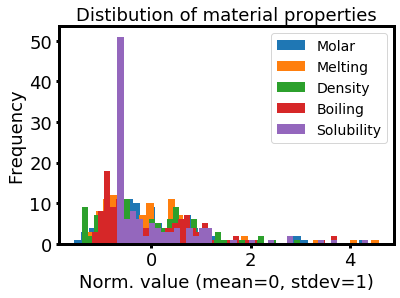

In [5]:
# get names of the properties we want to examine
props = df.columns[2:]

# loop over each property and plot a histogram of its values
for p in props:
    plt.hist(norm_arr(df[p]), bins=40, label=p.split(' ')[1], alpha=1)
plot_setup(labels=['Norm. value (mean=0, stdev=1)', 'Frequency'],
           title='Distibution of material properties')
plt.show()

## Examine correlations between different material properties

Here we plot each pair of material properties agaist each other in order to
examine the extent to which different properties are correlated.

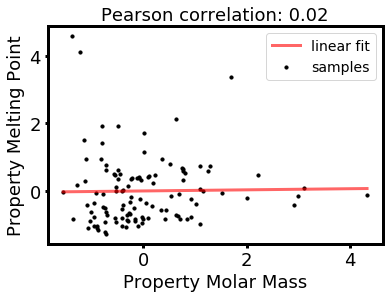

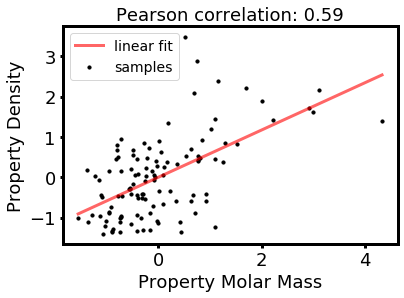

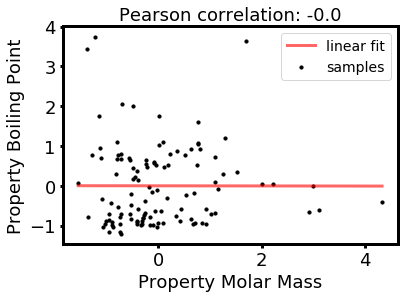

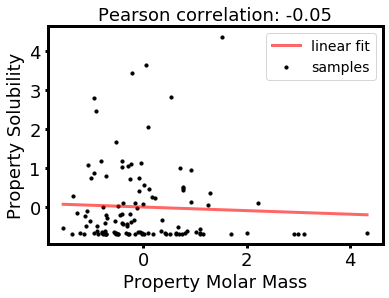

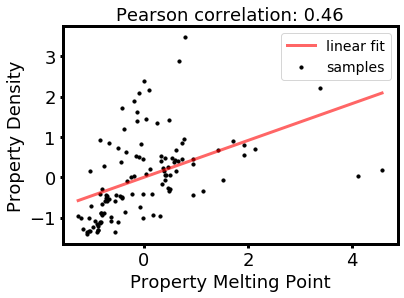

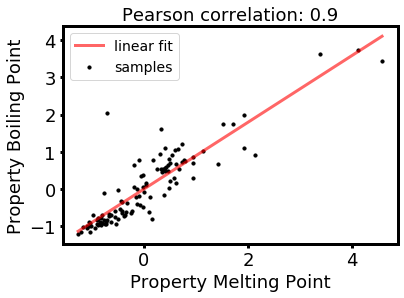

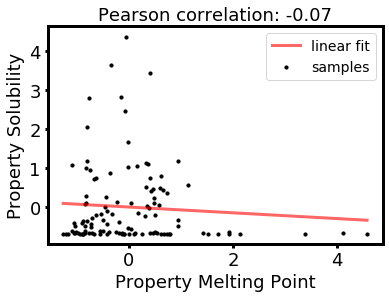

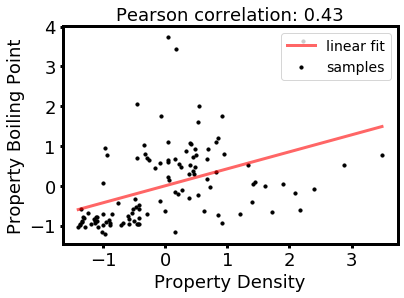

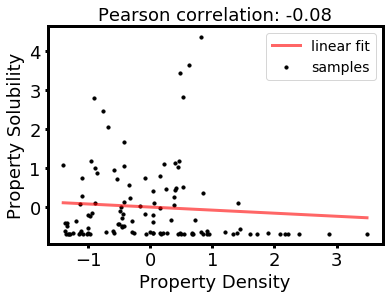

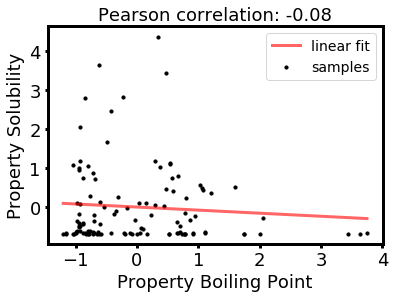

In [6]:
# create a list of pairs of properties
prop_pairs = list(itertools.combinations(props, 2))

# loop over each set of pairs
for combo in prop_pairs:
    # set x and y values and normalize
    x, y = norm_arr(df[combo[0]]), norm_arr(df[combo[1]])

    # find linear correlation between properties
    slope, intercept, r_val, p_val, _ = linregress(x, y)
    fitline_x = np.linspace(x.min(), x.max())
    fitline_y = intercept + fitline_x * slope

    # plot results
    plt.scatter(x, y, s=10, c='k', label='samples')
    plt.plot(fitline_x, fitline_y, lw=3, alpha=0.6, c='r', label='linear fit')
    plot_setup(labels=[combo[0], combo[1]],
               title='Pearson correlation: '+str(round(r_val, 2)))
    plt.show()

## Perform dimensionality reduction using t-SNE

Here we examine the data using the t-SNE method. To observe how each material
property is distributed across the components of the t-sne space, we
color each sample based on the value of the material property by looping
over each property.

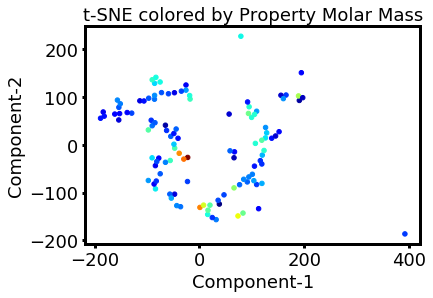

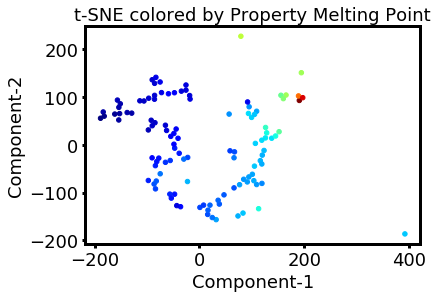

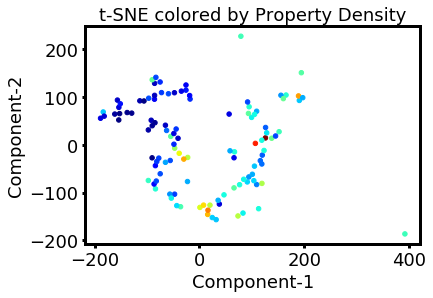

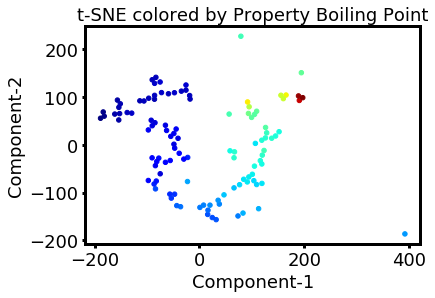

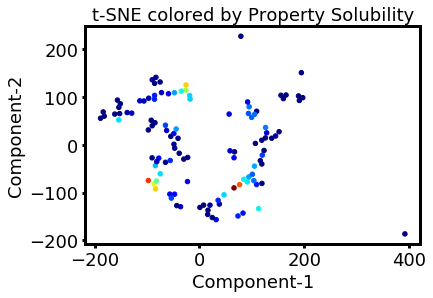

In [7]:
# perform t-SNE using the lowest recommended perplexity value
tsne = TSNE(n_components=2, random_state=0,
                perplexity=5).fit_transform(df[props].values)

# plot the t-SNE results and color them by looping over each property
for p in props:
    plt.scatter(tsne[:, 0], tsne[:, 1], s=20, c=df[p], cmap='jet')
    plot_setup(labels=['Component-1', 'Component-2'],
            title='t-SNE colored by '+p, legend=False)
    plt.show()

## Perform clustering

Now we perform some unsupervised clustering analysis on the t-SNE results
to exmine the degree of clustering present in the t-SNE space.


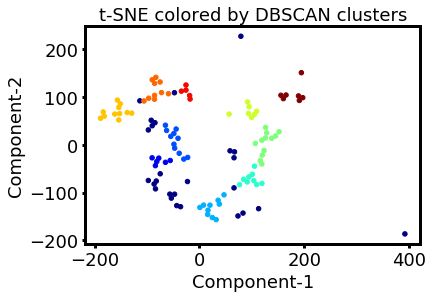

In [8]:
# perform clustering
clusters = OPTICS().fit(tsne)

# plot tsne color-coded by cluster
plt.scatter(tsne[:, 0], tsne[:, 1], s=20, c=clusters.labels_, cmap='jet')
plot_setup(labels=['Component-1', 'Component-2'],
        title='t-SNE colored by DBSCAN clusters', legend=False)
plt.show()

# Define machine learning problem

Here we define the machine learning problem, which is to predict the
material with the highest density from values of solubility,
molar mass, melting point, and boiling point.

In [9]:
# designate target response variable
tar_var = 'Property Density'

# get the list of the input variables
input_vars = [v for v in list(df)[2:] if v != tar_var]

# create array of target values
all_targets = df[tar_var].values
# create array of input values
all_inputs = df[input_vars].values

print('inputs shape: %s' %str(np.shape(all_inputs)))
print('targets shape: %s' %str(np.shape(all_targets)))

inputs shape: (114, 4)
targets shape: (114,)


## Examine acquistion functions

To predict density, we fit the machine learning model
(a random forest with uncertainty calculation) on a random selection of
10 observed materials. We predict the response value of each unobserved
material and calculate the uncertainty associated with each prediction.
Then we use the acquisition functions to determine which candidate
material to test (observe) next.

The plot below shows which candidates should be tested next based on the
recommendation of three acquisition functions:

1.   Maximum expected improvement (MEI) 
2.   Maximum uncertainty (MU)
3.   Maximum likihood of improvement (MLI)

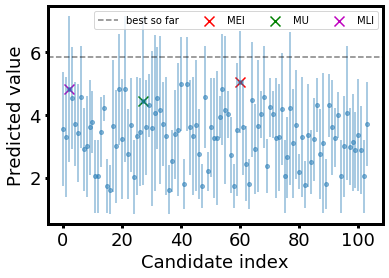

In [10]:
# create random forest regressor model
rf = RandomForestRegressor()

# get indices of 10 random observations to use as an initial dataset
obs_idx = random.sample(range(len(df)), 10)
# get indices of unobserved samples 
unobs_idx = [i for i in range(len(df)) if i not in obs_idx ]

# fit the random forest using the observations 
X = all_inputs[obs_idx]
y = all_targets[obs_idx]
rf.fit(X, y)

# get best observed value so far
best_so_far = np.max(y)

# use fitted model to get prediction and uncertainty for unobserved samples
y_pred, y_std = rf.predict(all_inputs[unobs_idx], return_std=True)

# get new candidate materials based on the acquisition functions
MEI_idx = np.argmax(y_pred)
MU_idx = np.argmax(y_std)
MLI_idx = np.argmax(y_pred + y_std)

# plot results
plt.scatter(MEI_idx, y_pred[MEI_idx], c='r', marker='x', s=100, label='MEI')
plt.scatter(MU_idx, y_pred[MU_idx], marker='x', c='g', s=100, label='MU')
plt.scatter(MLI_idx, y_pred[MLI_idx], marker='x', c='m', s=100, label='MLI')
plt.errorbar(np.arange(len(y_pred)), y_pred, yerr=y_std,
             fmt='o', alpha=0.5, markersize=4)
plt.axhline(y=best_so_far, color='k', linestyle='--', alpha=0.5, label='best so far')
plot_setup(labels=['Candidate index', 'Predicted value'], legend=False)
plt.legend(ncol=4)
plt.show()

Now that the random forest model and acquisition function strategies
have been implemented once, we can begin testing the process using a
sequential learning workflow (FUELS). We record how many iterations
(experiments, i.e. observations) are required before our model converges
to the best solution. We also compare performance of the the acquisition
functions to performance of random selection.

To get an idea of the statistical varition in how our acquisition functions
perform, we run the FUELS process using multiple iterations and take the
mean number of required trials. This process is statistical in nature since
we begin each run using 10 samples which were randomly selected.

In [0]:
def test_FUELS(inputs, targets, acq_fun='MEI', it=50):
    """Use the FUELS strategy to test the convergence of a model using
    different acquisition functions.
    -------------------------------------------------------------
    Arguments:
    inputs: 2D array of model input values (shape = (samples, features))
    targets: 1D array of model target values (shape = (samples,))
    acq_fun: acquisition function ('MEI', 'MU', 'MLI', or 'RANDOM')    
    it: iterations to repeat for statistical purposes
    -------------------------------------------------------------
    Returns: mean number of trials required for model convergence
    """
    # record start time to quantify time required for modeling
    start_time = time.time()

    # create random forest regressor model
    rf = RandomForestRegressor()

    # use the response of the best candidate sample to check for convergence
    best_idx = np.argmax(targets)

    # initialize list to keep track of statistical number of trials required
    trials_to_convergence = []

    # loop over the designated number of iterations for statistical averaging
    for it0 in range(it):

        # get indices of 10 random observations to use as an initial dataset
        obs_idx = random.sample(range(len(targets)), 10)
        # initialize the experiment trial counter
        trial = 0
        
        # run sequential trials until the best candidate is selected
        while best_idx not in obs_idx:

            # fit the random forest using the observations 
            X = inputs[obs_idx]
            y = targets[obs_idx]
            rf.fit(X, y)

            # get indices of unobserved samples 
            unobs_idx = [i for i in range(len(targets)) if i not in obs_idx]
            # use model to get predictions of unobserved samples
            y_pred, y_std = rf.predict(inputs[unobs_idx], return_std=True)

            # select new candidates based on the recommendation of
            # the acquisition function
            if acq_fun == 'MEI':
                new_idx = unobs_idx[np.argmax(y_pred)]
            if acq_fun == 'MU':
                new_idx = unobs_idx[np.argmax(y_std)]
            if acq_fun == 'MLI':
                new_idx = unobs_idx[np.argmax(y_pred + y_std)]
            if acq_fun == 'RANDOM':
                new_idx = random.choice(unobs_idx)

            # add new candidate to the observed samples
            obs_idx.append(new_idx)
            # increment the number of trials we have conducted
            trial += 1

        # after convergence occurs, record the number of required trials
        trials_to_convergence.append(float(trial))

    # find mean and stdev of the number of trials required for convergence
    mean_trials = np.mean(trials_to_convergence)
    std_trials = np.std(trials_to_convergence)
    print('\n%s converged after %0.2f +/- %0.2f trials' %(
                                    acq_fun, mean_trials, std_trials))
    print('duration: %0.2f minutes' %float((time.time()-start_time)/60))
    return mean_trials, std_trials

Now we can implement the FUELS strategy using a variety of different
acquisition functions.

In [12]:
# test the convergence rate using different acquisition functions
mei = test_FUELS(all_inputs, all_targets, acq_fun='MEI')
mu = test_FUELS(all_inputs, all_targets, acq_fun='MU')
mli = test_FUELS(all_inputs, all_targets, acq_fun='MLI')
rand = test_FUELS(all_inputs, all_targets, acq_fun='RANDOM')


MEI converged after 15.14 +/- 7.55 trials
duration: 0.26 minutes

MU converged after 26.92 +/- 14.41 trials
duration: 0.46 minutes

MLI converged after 14.38 +/- 9.02 trials
duration: 0.18 minutes

RANDOM converged after 50.70 +/- 32.25 trials
duration: 1.59 minutes


Compare performance of each acquisition function.

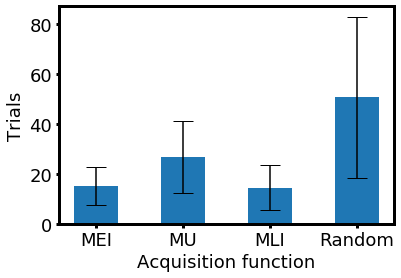

In [13]:
# extract mean and stdev of each acquisition function
trial_means = [mei[0], mu[0], mli[0], rand[0]]
trial_stdevs = [mei[1], mu[1], mli[1], rand[1]]

# plot results in bar graph
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['MEI', 'MU', 'MLI', 'Random'])
plt.bar([0, 1, 2, 3], trial_means, yerr=trial_stdevs, capsize=10, width=0.5)
plot_setup(labels=['Acquisition function', 'Trials'], legend=False)
plt.show()

## Assess final model performance

Here we train the random forest using all the data in order to assess
the model performance.

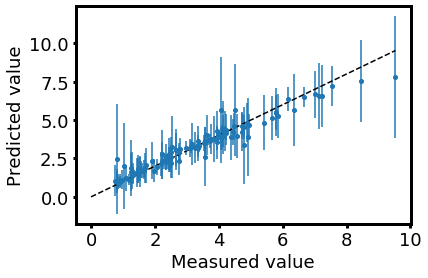

In [14]:
# fit the model using all avilable data
rf.fit(all_inputs, all_targets)

# use model to get the prediction and uncertainty of each predicted sample
all_pred, all_std = rf.predict(all_inputs, return_std=True)

# plot results
plt.errorbar(all_targets, all_pred, yerr=all_std, fmt='o', markersize=4)
plt.plot([0, np.max(all_targets)],
         [0, np.max(all_targets)],
         color='k', linestyle='--',)
plot_setup(labels=['Measured value', 'Predicted value'], legend=False)

plt.show()